In [1]:
import random as rn
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Progbar

In [2]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + 1:, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        # if self.mask_type == 'A':
        #     mask[center, center, :, :int(self.filters / 3)] = 0.
        #     mask[center, center, 1:, int(self.filters / 3):2 * int(self.filters / 3)] = 0.
        #     mask[center, center, 2:, 2 * int(self.filters / 3):] = 0.
        # else:
        #     mask[center, center, int(int(input_shape[-1]) / 3):, :int(self.filters / 3)] = 0.
        #     mask[center, center, 2 * int(int(input_shape[-1]) / 3):,
        #     int(self.filters / 3):2 * int(self.filters / 3)] = 0.
        #

        for i in range(3):
            for j in range(3):
                if (self.mask_type == 'A' and i >= j) or (self.mask_type == 'B' and i > j):
                    mask[
                    center,
                    center,
                    i::3,
                    j::3
                    ] = 0.
                    
        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

In [3]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

In [4]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')


In [5]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [6]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

height = 32
width = 32
n_channel = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)


In [7]:
# Quantise the input data in q levels
q_levels = 64
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)


In [8]:
batch_size = 256
train_buf = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)


In [9]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
# Prepare optimizer and loss function
lr_decay = 0.99995
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [11]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss


In [12]:
# Training loop
n_epochs = 10
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[("loss", loss)])

Epoch 1/10
196/196 [==============================] - 86s 441ms/step - loss: 3.2919
Epoch 2/10
196/196 [==============================] - 73s 373ms/step - loss: 2.2296
Epoch 3/10
196/196 [==============================] - 74s 378ms/step - loss: 1.8551
Epoch 4/10
196/196 [==============================] - 73s 375ms/step - loss: 1.7183
Epoch 5/10
196/196 [==============================] - 74s 378ms/step - loss: 1.5588
Epoch 6/10
196/196 [==============================] - 74s 375ms/step - loss: 1.5321
Epoch 7/10
196/196 [==============================] - 74s 376ms/step - loss: 1.4686
Epoch 8/10
196/196 [==============================] - 74s 377ms/step - loss: 1.2500
Epoch 9/10
196/196 [==============================] - 74s 376ms/step - loss: 1.2264
Epoch 10/10
196/196 [==============================] - 74s 377ms/step - loss: 1.3086



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



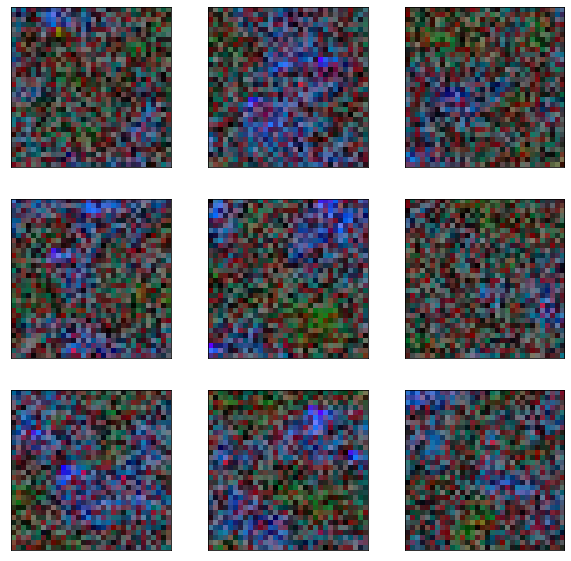

In [13]:
# Generating new images
samples = np.zeros((10, height, width, n_channel)) + 0.5 * np.random.rand(10, height, width, n_channel)

for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()



---



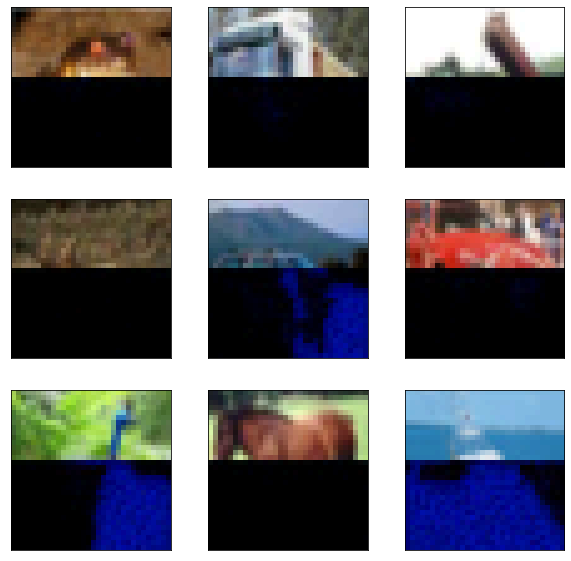

In [14]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
occlude_start_row = 14
num_generated_images = 1
samples = np.copy(x_train_quantised[:10, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()